## Overshooting top. Dedka algorithm

In [2]:
import os
from netCDF4 import Dataset
import numpy as np
import matplotlib as mpl
#mpl.use('TkAgg')
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap, cm
from matplotlib.colors import ListedColormap
from scipy import ndimage

import to_palette as pal
import read_tropo as tropo

In [3]:
#получение температуры тропопаузы 
# координаты в градусах
def getTropo(lat, lon):
    num_fi, num_la = tropo.getNumPoFila(np.deg2rad(lat), np.deg2rad(lon), tropo.step_fi, tropo.step_la, 
                                        tropo.fi0, tropo.la0, tropo.fi_size, tropo.la_size)

    return tropo.data[num_fi, num_la]

In [4]:
temp = getTropo(-87, -180)
temp

-57.160366

In [5]:
# Вывод данных в виде изображения
# data - массив данных
# title - подпись к изоюражению
# size - размер подложки
def show_img(data, title = "", size = 15, cmap_user = plt.cm.cool):
    plt.figure(figsize=(size, size))
    plt.imshow(data, cmap_user)#, cmap = plt.cm.cividis) #cividis #tab20c
    plt.xlabel(title)    
    plt.show()
    plt.close()
    
def show_gray(data, title ="", size = 15):
    plt.figure(figsize=(size, size))
    plt.imshow(data, cmap=plt.cm.gray)
    plt.xlabel(title)
    #plt.colorbar()
    plt.show()
    plt.close()
    
# Вывод списка изображений
# data - массив данных
# title - подпись к изоюражению
# size - размер подложки
def show_imgs(data, rows, cols, size, title='img'):
    plt.figure(figsize=(size * cols, size * rows))
    #plt.imshow(data, cmap=plt.cm.gray)
    for num in range(len(data)):
        plt.subplot(rows, cols, num + 1)
        plt.imshow(data[num], plt.cm.jet)
        plt.xlabel(title)
    plt.show()
    plt.close()


In [6]:
def only_data_grab(g16_data_file):    
    # designate dataset
    g16nc = Dataset(g16_data_file, 'r')
    var_names = [ii for ii in g16nc.variables]
    var_name = var_names[0]

    # data info    
    data = g16nc.variables[var_name][:]
    
    # close file when finished
    g16nc.close()
    g16nc = None
    
    return data

In [7]:
def lat_lon_reproj(g16_data_file): 
    print("grid from", g16_data_file) # print file name
    # designate dataset
    g16nc = Dataset(g16_data_file, 'r')

    data_time_grab = ((g16nc.time_coverage_end).replace('T',' ')).replace('Z','')
    
    # GOES-R projection info and retrieving relevant constants
    proj_info = g16nc.variables['goes_imager_projection']
    lon_origin = proj_info.longitude_of_projection_origin
    H = proj_info.perspective_point_height+proj_info.semi_major_axis
    r_eq = proj_info.semi_major_axis
    r_pol = proj_info.semi_minor_axis

    # grid info
    lat_rad_1d = g16nc.variables['x'][:]
    lon_rad_1d = g16nc.variables['y'][:]
    
    # close file when finished
    g16nc.close()
    g16nc = None

    # create meshgrid filled with radian angles
    lat_rad,lon_rad = np.meshgrid(lat_rad_1d,lon_rad_1d)

    # lat/lon calc routine from satellite radian angle vectors

    lambda_0 = (lon_origin*np.pi)/180.0

    a_var = np.power(np.sin(lat_rad),2.0) + (np.power(np.cos(lat_rad),2.0)*(np.power(np.cos(lon_rad),2.0)+(((r_eq*r_eq)/(r_pol*r_pol))*np.power(np.sin(lon_rad),2.0))))
    b_var = -2.0*H*np.cos(lat_rad)*np.cos(lon_rad)
    c_var = (H**2.0)-(r_eq**2.0)

    r_s = (-1.0*b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)

    s_x = r_s*np.cos(lat_rad)*np.cos(lon_rad)
    s_y = - r_s*np.sin(lat_rad)
    s_z = r_s*np.cos(lat_rad)*np.sin(lon_rad)

    # latitude and longitude projection for plotting data on traditional lat/lon maps
    lat = (180.0/np.pi)*(np.arctan(((r_eq*r_eq)/(r_pol*r_pol))*((s_z/np.sqrt(((H-s_x)*(H-s_x))+(s_y*s_y))))))
    lon = (lambda_0 - np.arctan(s_y/(H-s_x)))*(180.0/np.pi)

    return lat, lon, data_time_grab

In [8]:
#создание маски в виде заполненной окружности
def create_fill_circular_mask(size, center, radius):
    Y, X = np.ogrid[:size[0], :size[1]]
    dist_from_center = np.sqrt((X - center[1])**2 + (Y-center[0])**2)

    mask = dist_from_center <= radius
    return mask

#создание маски в виде окружности
def create_circular_mask(size, center, radius):
    Y, X = np.ogrid[:size[0], :size[1]]
    dist_from_center = np.sqrt((X - center[1])**2 + (Y-center[0])**2)

    mask = (dist_from_center <= radius + 1) & (dist_from_center > radius)
    #mask = dist_from_center == radius + 1
    return mask


In [9]:
#создание отдельных масок из выделенных участков
def create_labels(mask, rm_thresh = 3):
    label_im, nb_labels = ndimage.label(mask)
    #print("labels=", nb_labels)

    # Remove small component
    sizes = ndimage.sum(mask, label_im, range(nb_labels + 1))
    #print("sizes=", sizes, sizes.shape)

    mask_size = sizes < rm_thresh
    remove_pixel = mask_size[label_im]

    #print("remove_pixel", remove_pixel, remove_pixel.shape)

    label_im[remove_pixel] = 0
    labels = np.unique(label_im)
    return labels, label_im
    #print("remain labels", labels)
    #label_im = np.searchsorted(labels, label_im)
    #show_img(label_im, cmap_user=plt.cm.jet)

In [10]:
#нахождение OT в выделенном участке
def find_ot_areas(candidate, chm):
    mx = np.ma.masked_where(~(chm < 225), chm)
    circm = create_circular_mask(chm.shape, candidate, 4)
    mx = np.ma.masked_array(chm, mx.mask |  ~(circm))   
    count = mx.compressed().size                
    if count >= 6:        
        thresh = np.mean(mx) - chm[candidate]        
        if thresh >= 6.5:            
            circm = create_fill_circular_mask(chm.shape, candidate, 3)
            ot_area = circm & (chm < np.mean(mx) - (np.mean(mx) - chm[candidate]) / 2)
            return ot_area
    return np.zeros(chm.shape)
   

In [11]:
FILL_RADIUS = 7.5 #для отбора кандидатов
cmap_ir11 = ListedColormap(pal.ir11_palette[::-1] / 255)

In [12]:
# Указание файла для чтения
nc_folder = './data/'


#nc_file = "OR_ABI-L2-CMIPF-M6C14_G16_s20192151630520_e20192151640228_c20192151640313.nc"
nc_file = "OR_ABI-L2-CMIPF-M6C14_G17_s20210910000319_e20210910009385_c20210910009454.nc"

In [13]:
print("file", nc_file)

file OR_ABI-L2-CMIPF-M6C14_G17_s20210910000319_e20210910009385_c20210910009454.nc


In [14]:
# считываем данные
templ_name = nc_file.split('_')[3]
ch = only_data_grab(nc_folder + nc_file) 


In [15]:
ch.shape

(5424, 5424)

In [15]:
#show_gray(ch)

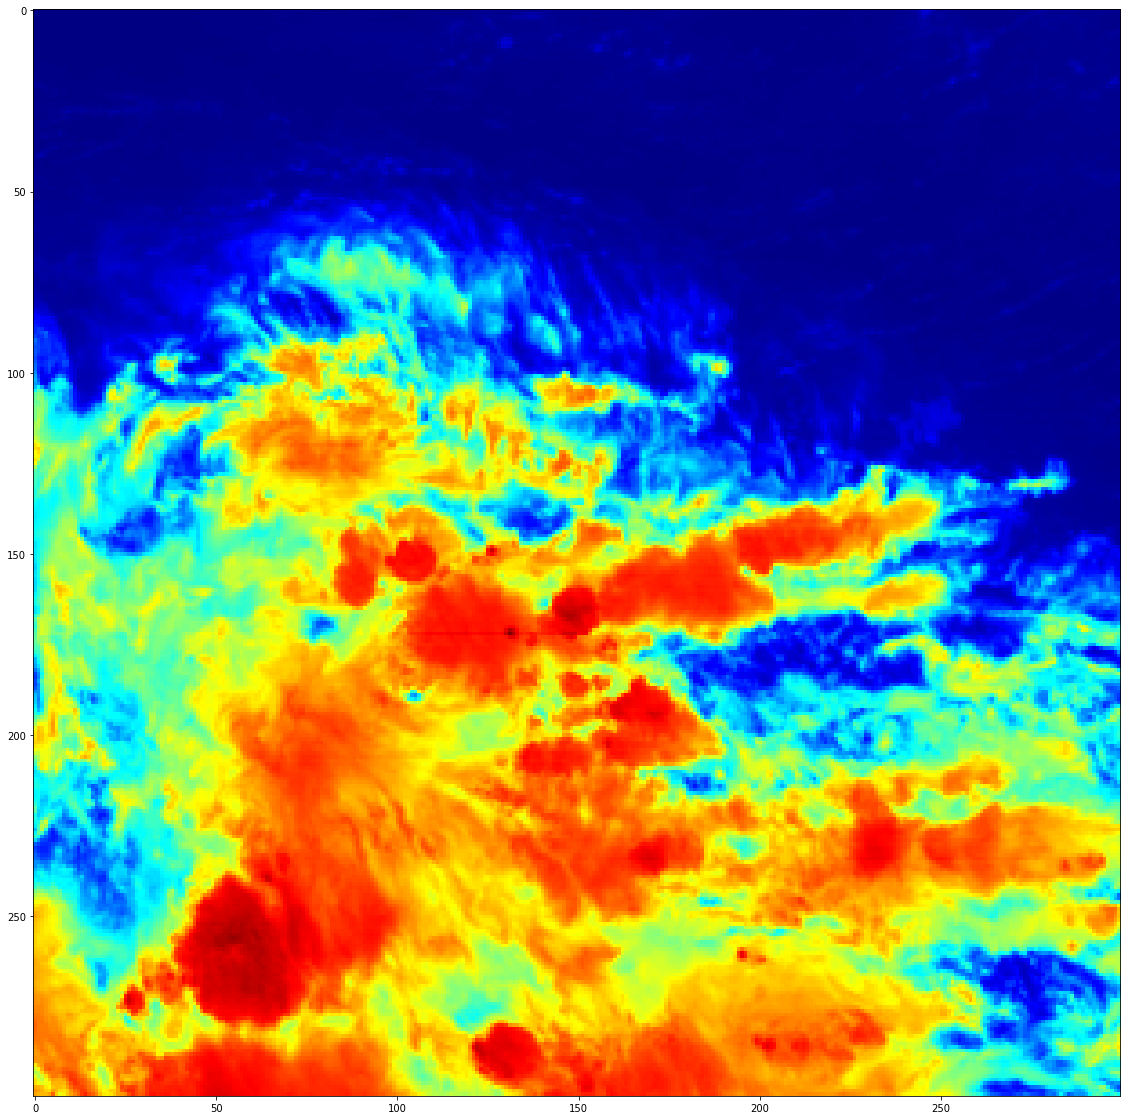

In [53]:
show_img(ch[3000:3300, 1200:1500], "", 20, cmap_ir11)

In [26]:
#nc_folder = './data/'

nc_file_v = "OR_ABI-L1b-RadF-M6C02_G17_s20210910000319_e20210910009385_c20210910009412.nc"

In [27]:
print("file_v", nc_file_v)

file_v OR_ABI-L1b-RadF-M6C02_G17_s20210910000319_e20210910009385_c20210910009412.nc


In [18]:
templ_name = nc_file_v.split('_')[3]



In [19]:
chv.shape

(21696, 21696)

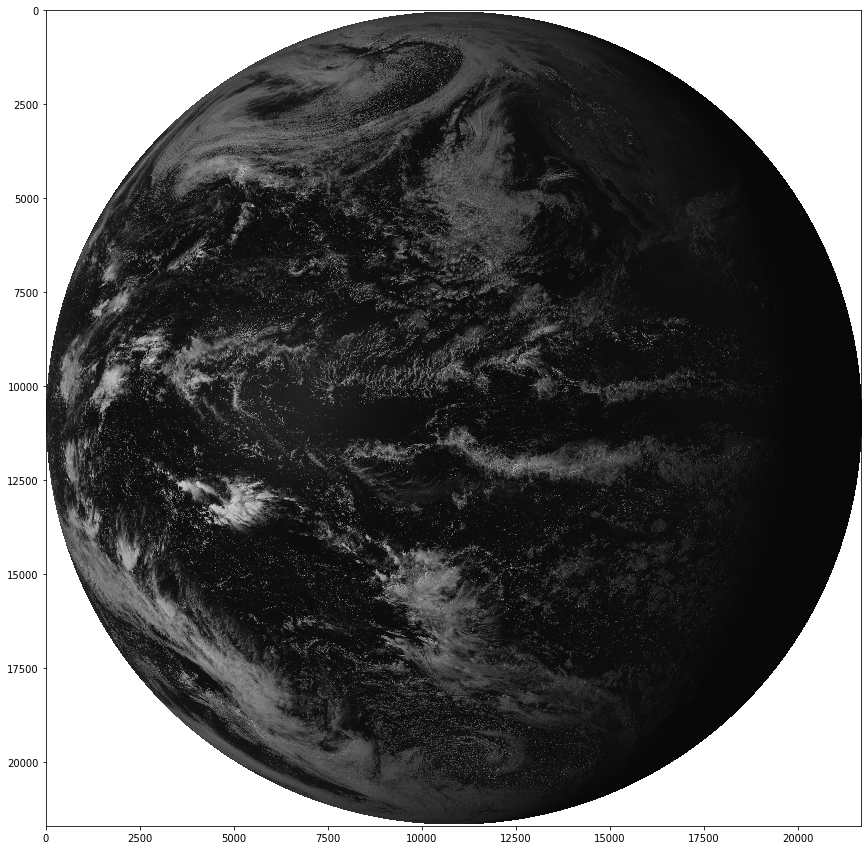

In [20]:
show_gray(chv)

grid from ./data/OR_ABI-L2-CMIPF-M6C14_G17_s20210910000319_e20210910009385_c20210910009454.nc


/home/maria/doc/job/study/practice/.env/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in sqrt
/home/maria/doc/job/study/practice/.env/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in sqrt


labels [ 0  1  2  5  7  9 11 12 13 14 15 16 18 20 21 22 23 24 25 26 28 29 32 33
 34 37 38 39 40 41 42 43 44 45 46 47 48 49 51 52 54 55 58 59 61 63 65 66
 71]
Число кандидатов 49


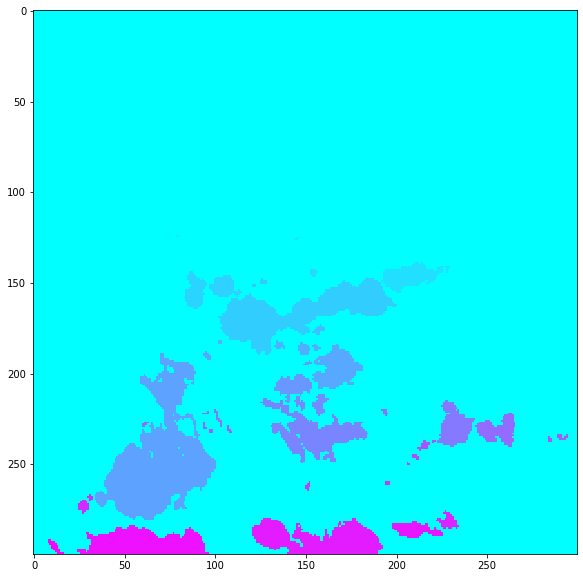

Проверяем каждый участок
num= 1
temp, chm[candidate] -80.1807632446289 -60.01163330078123
ok

num= 2
temp, chm[candidate] -80.1807632446289 -59.89194335937498
ok

num= 5
temp, chm[candidate] -80.1807632446289 -58.575216674804665
ok

num= 7
temp, chm[candidate] -78.80575561523438 -59.29343261718748
ok

num= 9
temp, chm[candidate] -78.80575561523438 -66.71491088867185
ok

temp, chm[candidate] -78.80575561523438 -66.11640014648435
ok

temp, chm[candidate] -78.80575561523438 -63.90192260742185
ok

temp, chm[candidate] -78.80575561523438 -60.90939941406248
ok

temp, chm[candidate] -78.80575561523438 -60.66998901367185
ok

temp, chm[candidate] -78.80575561523438 -60.25104370117185
ok

temp, chm[candidate] -78.80575561523438 -58.39566650390623
ok

num= 11
temp, chm[candidate] -78.80575561523438 -60.72983398437498
ok

num= 12
temp, chm[candidate] -80.1807632446289 -65.75729980468748
ok

temp, chm[candidate] -80.1807632446289 -62.704916381835915
ok

temp, chm[candidate] -80.1807632446289 -62.40

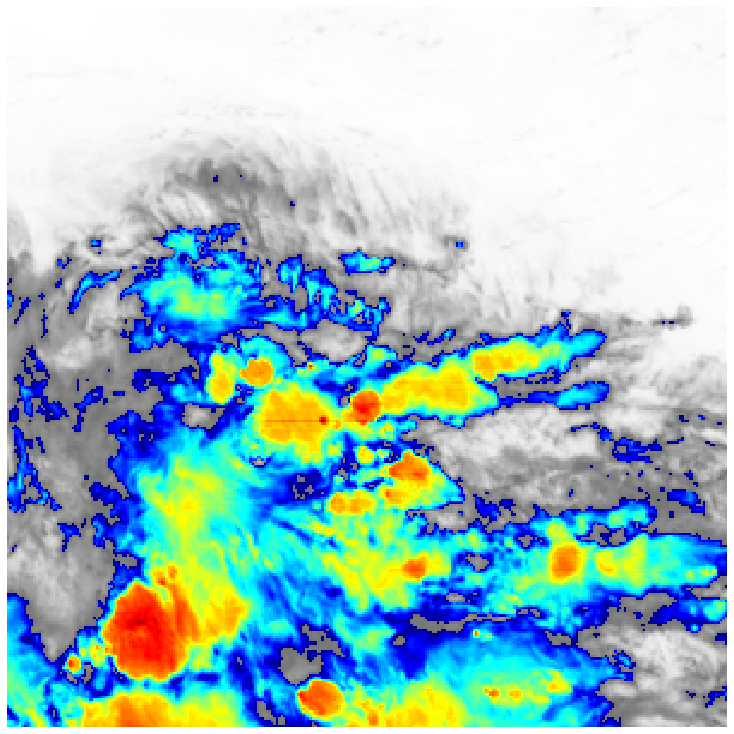

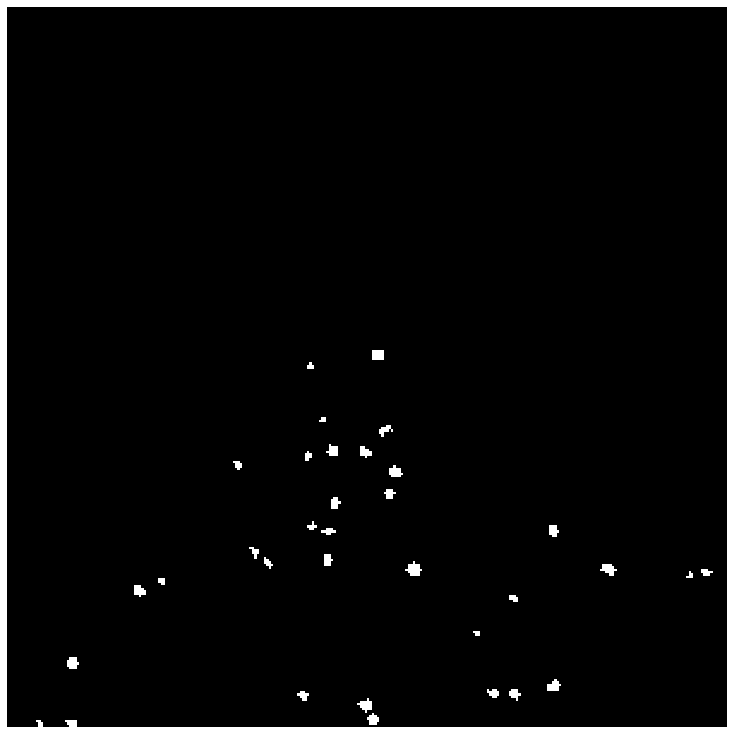

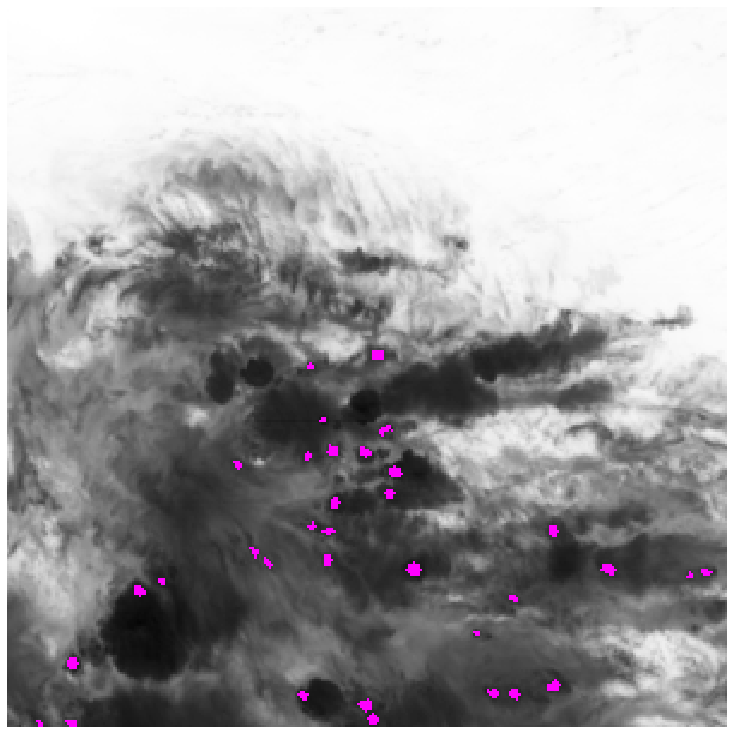

In [57]:
#для участка шарика
#1 участок
row = 3000
col = 1200
dx = 300

#2 участок
#row = 2000
#col = 3000
#dx = 500

#3 участок 
#row = 3500
#col = 500
#dx = 500



#15
# 500 : 5000 : dx = 500


lat, lon, dt = lat_lon_reproj(nc_folder + nc_file)
lat = lat[row:row+dx, col:col+dx]
lon = lon[row:row+dx, col:col+dx]

row_v = row * 4
col_v = col * 4
dx_v = dx * 4

#lat, lon, dt = lat_lon_reproj(nc_folder + nc_fi#le)
#lat = lat[row:row+dx, col:col+dx]
#lon = lon[row:row+dx, col:col+dx]

chm = ch.copy()[row:row+dx, col:col+dx]
chm = np.ma.masked_greater(chm, 240) #отбрасываем, где темпа больше 240

mask = chm <= 215 #там, где м.б. OT
ot_mask = np.zeros(chm.shape)

labels,label_im = create_labels(mask, 3)
print("labels", labels)
print("Число кандидатов", labels.size)
show_img(label_im, size=10)

print("Проверяем каждый участок")
for num in labels:
    if num == 0:
        continue
    print("num=", num)
    mask_one = label_im == num
    mx = np.ma.masked_array(chm, mask=~mask_one)
    while mx.compressed().size > 1:    
        #check ot
        candidate = np.unravel_index(np.argmin(mx, axis=None), mx.shape)        
        #print("coord", lat[candidate], lon[candidate])  
        #chm[candidate] - температуру вершины. надо сравнить с темп тропо
        temp = getTropo(lat[candidate], lon[candidate])+ 273.15
        print("temp, chm[candidate]", temp- 273.15, chm[candidate]- 273.15)
        if chm[candidate] <= 9999: #temp + 3:
            print("ok\n");
            #print("temp, chm[candidate]", temp, chm[candidate])
            ot_area = find_ot_areas(candidate, chm)
            ot_mask += ot_area.astype(bool)
        #mask ot candidate
        circm = create_fill_circular_mask(mx.shape, candidate, FILL_RADIUS)
        mx = np.ma.masked_array(mx, mx.mask | circm)
        

        
#TODO для канала видимого диапазона 
#указать имя файла
#считать данные
#row_v = row * 4
#col_v = 
#dx_v = 
#chv = chv[ , ]
#show_gray(chv)        
        
## отображение и сохранение картинок в разном виде (с от, только маску и пр)
#chv_s = chv.copy()[row_v:row_v+dx_v, col_v:col_v+dx_v]
#plt.figure(figsize=(15, 15))
#ax = plt.axes([0,0,1,1], frameon=False)
#ax.set_axis_off()
#plt.imshow(chv_s, cmap=plt.cm.gray)
#plt.savefig(templ_name + '_' + str(row) + '_' + str(col) + 'vis.png', 
#            dpi=150, bbox_inches='tight', pad_inches=0)
#np.save(templ_name + '_' + str(row) + '_' + str(col) + 'vis.npy', 
#        np.ma.filled(vis, np.nan))
#plt.show()
#plt.close()

fsize = 10 
      


plt.figure(figsize=(10, 10))   
ax = plt.axes([0,0,1,1], frameon=False)
ax.set_axis_off()
plt.imshow(ch[row:row+dx, col:col+dx], cmap=plt.cm.gray)
plt.imshow(chm, cmap=cmap_ir11)
#plt.savefig(templ_name + '_' + str(row) + '_' + str(col) + 'full_ir.png', 
#            dpi=150, bbox_inches='tight', pad_inches=0)        
#np.save(templ_name + '_' + str(row) + '_' + str(col) + 'full_ir.npy', 
#        np.ma.filled(ch[row:row+1000, col:col+1000], np.nan))
plt.show()
plt.close()

plt.figure(figsize=(fsize, fsize))
ax = plt.axes([0,0,1,1], frameon=False)
ax.set_axis_off()
plt.imshow(ot_mask, cmap=plt.cm.gray)
#plt.savefig(templ_name + '_' + str(row) + '_' + str(col) + 'mask_n.png', 
#            dpi=150, bbox_inches='tight', pad_inches=0)
#np.save(templ_name + '_' + str(row) + '_' + str(col) + 'mask.npy', np.ma.filled(ot_mask, np.nan))
plt.show()
plt.close()

ot_mask_masked = np.ma.masked_where(ot_mask == False, ot_mask)
plt.figure(figsize=(10, 10))
ax = plt.axes([0,0,1,1], frameon=False)
ax.set_axis_off()
plt.imshow(ch[row:row+dx, col:col+dx], cmap=plt.cm.gray)
plt.imshow(ot_mask_masked, cmap=plt.cm.spring)
#plt.savefig(templ_name + '_' + str(row) + '_' + str(col) + '_mask_with.png', dpi=150)        
plt.show()
plt.close()

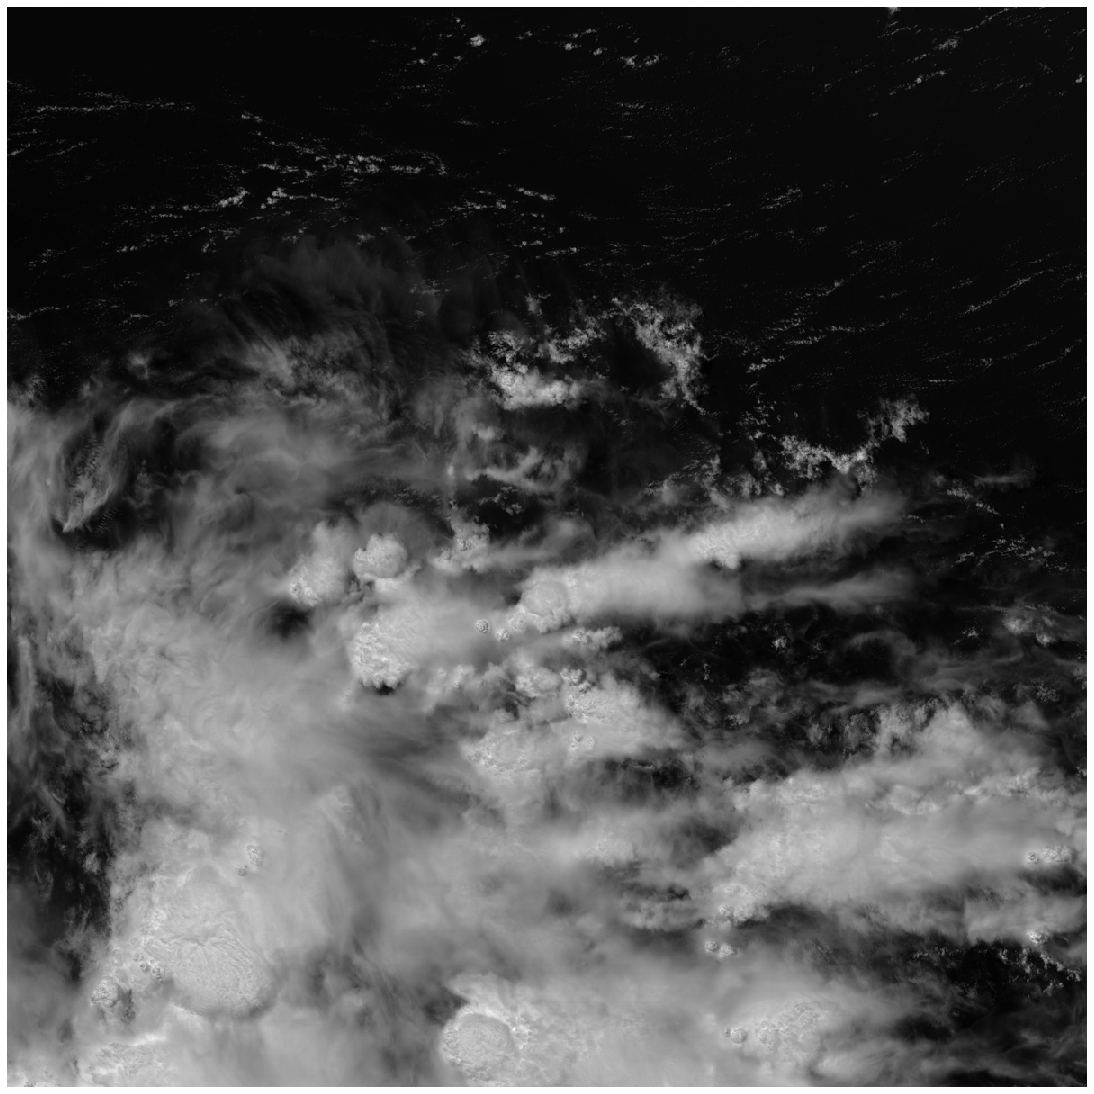

In [58]:
chv_s = only_data_grab(nc_folder + nc_file_v)[row_v:row_v+dx_v, col_v:col_v+dx_v]
plt.figure(figsize=(15, 15))
ax = plt.axes([0,0,1,1], frameon=False)
ax.set_axis_off()
plt.imshow(chv_s, cmap=plt.cm.gray)
#plt.savefig(templ_name + '_' + str(row) + '_' + str(col) + 'vis.png', 
#            dpi=150, bbox_inches='tight', pad_inches=0)
#np.save(templ_name + '_' + str(row) + '_' + str(col) + 'vis.npy', 
#        np.ma.filled(vis, np.nan))
plt.show()
plt.close()
